# Train Front RGB image to BEV on simulation dataset

## Library

In [3]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import timm
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision import models
from tqdm import tqdm

## Dataset

In [4]:
def apply_roi_mask(bev_tensor, roi_angle=90):
    """
    Compute ROI mask for a single BEV tensor.
    Accepts shape [C, H, W], [H, W], or [1, H, W].
    Returns mask of shape [1, H, W].
    """
    if bev_tensor.dim() == 3 and bev_tensor.shape[0] in [1, 3]:  # [C, H, W]
        H, W = bev_tensor.shape[-2:]
    elif bev_tensor.dim() == 2:  # [H, W]
        H, W = bev_tensor.shape
    elif bev_tensor.dim() == 3 and bev_tensor.shape[0] == 384 and bev_tensor.shape[1] == 384:
        # Incorrectly shaped [H, W, C], e.g. from PIL -> torch conversion mistake
        raise ValueError("Expected shape [C, H, W] but got [H, W, C]")
    else:
        raise ValueError(f"Invalid bev_tensor shape: {bev_tensor.shape}")

    cx, cy = W // 2, H // 2
    Y, X = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
    dx = X - cx
    dy = cy - Y

    angles = torch.rad2deg(torch.atan2(dy.float(), dx.float()))
    distances = torch.sqrt(dx.float()**2 + dy.float()**2)
    radius = H

    mask = ((angles >= -roi_angle / 2 + 90) & (angles <= roi_angle / 2 + 90) & (distances <= radius)).float()
    return mask.unsqueeze(0)  # [1, H, W]

class RGBToBEVDataset(Dataset):
    def __init__(self, front_dir, bev_dir):
        fronts = sorted([f for f in os.listdir(front_dir) if f.endswith(".png")])
        bevs = sorted([f for f in os.listdir(bev_dir) if f.endswith(".png")])
        self.pairs = [(os.path.join(front_dir, f), os.path.join(bev_dir, f))
                      for f in fronts if f in bevs]  # Only matching filenames

        assert len(self.pairs) > 0, "No matching image pairs found."

        self.front_transform = transforms.Compose([
            transforms.Resize((384, 384)),
            transforms.ColorJitter(0.2, 0.2, 0.1, 0.05),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])
        self.bev_transform = transforms.Compose([
            transforms.Resize((384, 384), interpolation=Image.NEAREST),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        front_path, bev_path = self.pairs[idx]
        front = Image.open(front_path).convert("RGB")
        bev = Image.open(bev_path)
        front_tensor = self.front_transform(front)
        bev_tensor = self.bev_transform(bev).float()
        roi_mask = apply_roi_mask(bev_tensor, roi_angle=90).to(bev_tensor.device)
        bev_tensor = bev_tensor * roi_mask
        return front_tensor, bev_tensor



In [5]:
front_dir = "../data/images_aligned/front"
bev_dir = "../data/images_aligned/bev"

dataset = RGBToBEVDataset(front_dir, bev_dir)
front, bev = dataset[0]
print(front.shape)  # [3, 384, 512]
print(bev.shape)    # [512, 512]
print(bev.dtype)    # torch.int64

torch.Size([3, 384, 384])
torch.Size([3, 384, 384])
torch.float32


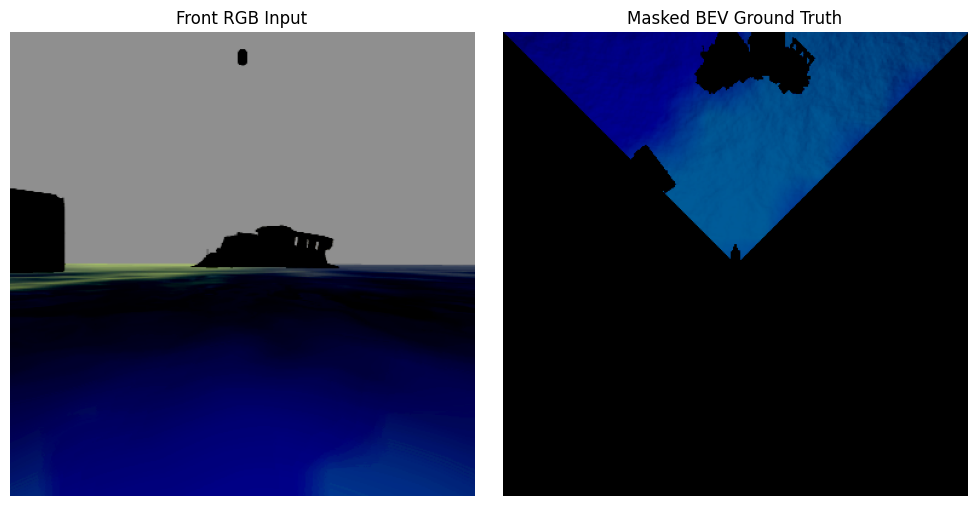

In [6]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch

def visualize_sample(dataset, idx=0, apply_mask=False, roi_angle=90):
    rgb, bev = dataset[idx]  # [3, H, W] or sometimes (1, 3, H, W)

    # Remove extra dimension if present
    if bev.ndim == 4:
        bev = bev.squeeze(0)
    if rgb.ndim == 4:
        rgb = rgb.squeeze(0)

    assert rgb.ndim == 3 and rgb.shape[0] == 3, f"Expected RGB of shape [3, H, W], got {rgb.shape}"
    assert bev.ndim == 3 and bev.shape[0] == 3, f"Expected BEV of shape [3, H, W], got {bev.shape}"

    rgb_img = TF.to_pil_image(rgb.clamp(0, 1))

    if apply_mask:
        with torch.no_grad():
            roi_mask = apply_roi_mask(bev, roi_angle=roi_angle)  # [1, H, W]
            roi_mask = roi_mask.expand(3, -1, -1)  # [3, H, W] for RGB masking
            masked_bev = bev * roi_mask
            bev_img = TF.to_pil_image(masked_bev.clamp(0, 1))
    else:
        bev_img = TF.to_pil_image(bev.clamp(0, 1))

    # Plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_img)
    plt.title("Front RGB Input")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(bev_img)
    plt.title("Masked BEV Ground Truth" if apply_mask else "BEV Ground Truth")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
visualize_sample(dataset, idx=0, apply_mask=True)



## model

In [7]:
class FrontToBEVUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=4):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),   # [B, 32, 192, 256]
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),            # [B, 64, 96, 128]
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)            # [B, 128, 48, 64]
        )
        self.middle = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), nn.ReLU(),       # [B, 128, 96, 128]
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.ReLU(),        # [B, 64, 192, 256]
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(),         # [B, 32, 384, 512]
            nn.Conv2d(32, out_channels, 1),                                        # [B, C, 384, 512]
        )
        self.output_resizer = nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False)

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return self.output_resizer(x)  # Final [B, C, 512, 512]

class ViTUNet(nn.Module):
    def __init__(self, image_size=(384, 384), out_channels=3, backbone='vit_base_patch16_384'):
        super().__init__()
        self.image_size = image_size
        self.out_channels = out_channels

        # Vision Transformer encoder
        self.encoder = timm.create_model(backbone, pretrained=True, features_only=True)
        encoder_channels = self.encoder.feature_info[-1]['num_chs']

        # Decoder with smoother upsampling
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(encoder_channels, 256, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()  # normalize RGB to [0,1]
        )

    def forward(self, x):  # x: [B, 3, H, W]
        feats = self.encoder(x)[-1]  # [B, C, H/32, W/32]
        out = self.decoder(feats)    # [B, 3, H, W]
        out = F.interpolate(out, size=self.image_size, mode='bilinear', align_corners=False)
        return out        # [B, 3, 384, 384]

class EnhancedViTUNet(nn.Module):
    def __init__(self, image_size=(384, 384), out_channels=3, backbone='vit_base_patch16_384'):
        super().__init__()
        self.encoder = timm.create_model(backbone, pretrained=True, features_only=True)
        feature_channels = [f['num_chs'] for f in self.encoder.feature_info]  # likely [96, 192, 384]

        self.decoder_head = nn.Conv2d(feature_channels[-1], 256, kernel_size=1)

        self.up1 = nn.Sequential(
            nn.Conv2d(256 + feature_channels[-2], 256, kernel_size=3, padding=1), nn.ReLU()
        )
        self.up2 = nn.Sequential(
            nn.Conv2d(256 + feature_channels[-3], 128, kernel_size=3, padding=1), nn.ReLU()
        )

        self.final_conv = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, out_channels, kernel_size=1)
        )

    def forward(self, x):
        feats = self.encoder(x)
        x = self.decoder_head(feats[-1])

        x = F.interpolate(x, size=feats[-2].shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, feats[-2]], dim=1)
        x = self.up1(x)

        x = F.interpolate(x, size=feats[-3].shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, feats[-3]], dim=1)
        x = self.up2(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        out = self.final_conv(x)
        out = F.interpolate(out, size=(384, 384), mode='bilinear', align_corners=False)
        return out


class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(pretrained=True).features[:16]  # up to conv3_3
        self.vgg = vgg.eval()
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, x, y):
        if x.shape[1] != 3:
            x = x.repeat(1, 3, 1, 1)
            y = y.repeat(1, 3, 1, 1)
        return F.l1_loss(self.vgg(x), self.vgg(y))

## Training

In [8]:
_, example_bev = dataset[0]  # shape: [1, 3, H, W] or [C, H, W]

# If shape is [1, 3, H, W], squeeze first dimension
if example_bev.ndim == 4:
    example_bev = example_bev.squeeze(0)  # shape: [3, H, W]
# Apply ROI mask (output shape: [H, W])
roi_mask = apply_roi_mask(example_bev, roi_angle=90)

# Convert to [1, 1, H, W] and ensure float
roi_mask = roi_mask.unsqueeze(0).float()

# ✅ Ensure the input shape is 4D: [B=1, C=1, H, W]
assert roi_mask.ndim == 4, f"Expected 4D mask, got {roi_mask.shape}"

# Interpolate to 384×384
roi_mask = F.interpolate(roi_mask, size=(384, 384), mode='nearest')

# Binarize and move to GPU
static_roi = (roi_mask > 0.5).float().to("cuda")  # [1, 1, 384, 384]

def train_rgb_to_bev(front_dir, bev_dir, batch_size=8, epochs=20, device='cuda'):
    dataset = RGBToBEVDataset(front_dir, bev_dir)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = EnhancedViTUNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    pixel_criterion = nn.L1Loss(reduction='none')
    vgg_criterion = VGGPerceptualLoss().to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for rgb, bev in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            rgb, bev = rgb.to(device), bev.to(device)
            pred = model(rgb)

            # Compute ROI mask for each image in batch
            # Compute ROI mask for each image in batch
            roi_masks = static_roi.expand(pred.shape[0], -1, -1, -1)  # [B, 1, H, W]

            roi_masks = roi_masks.to(device)  # [B, 1, H, W]
            roi_masks = F.interpolate(roi_masks, size=pred.shape[-2:], mode='nearest')  # [B, 1, H', W']

            loss_mask = roi_masks.expand_as(pred)
            
            # Apply mask
            masked_pred = pred * loss_mask
            masked_bev = bev * loss_mask

            pixel_loss = pixel_criterion(masked_pred, masked_bev)  # [B, C, H, W]
            pixel_loss = pixel_loss.sum() / loss_mask.sum()

            # Perceptual loss (on whole image)
            perceptual_loss = vgg_criterion(pred, bev)

            # Total loss
            loss = pixel_loss + 0.1 * perceptual_loss  # weight can be tuned

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(dataloader):.4f}")

        # Save one example
        vutils.save_image(pred[0].detach().cpu(), f"./output/pred_{epoch}.png")
        vutils.save_image(bev[0].detach().cpu(), f"./output/gt_{epoch}.png")

    return model

In [7]:


model = train_rgb_to_bev(
    front_dir="../data/images_aligned/front",
    bev_dir="../data/images_aligned/bev",
    epochs=20,
    batch_size=4
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/20: 100%|██████████| 1011/1011 [09:37<00:00,  1.75it/s]


Epoch 1/20 - Loss: 0.0567


Epoch 2/20: 100%|██████████| 1011/1011 [09:37<00:00,  1.75it/s]


Epoch 2/20 - Loss: 0.0519


Epoch 3/20: 100%|██████████| 1011/1011 [09:37<00:00,  1.75it/s]


Epoch 3/20 - Loss: 0.0518


Epoch 4/20: 100%|██████████| 1011/1011 [09:35<00:00,  1.76it/s]


Epoch 4/20 - Loss: 0.0503


Epoch 5/20: 100%|██████████| 1011/1011 [09:37<00:00,  1.75it/s]


Epoch 5/20 - Loss: 0.0487


Epoch 6/20: 100%|██████████| 1011/1011 [09:32<00:00,  1.77it/s]


Epoch 6/20 - Loss: 0.0459


Epoch 7/20: 100%|██████████| 1011/1011 [09:21<00:00,  1.80it/s]


Epoch 7/20 - Loss: 0.0425


Epoch 8/20: 100%|██████████| 1011/1011 [09:24<00:00,  1.79it/s]


Epoch 8/20 - Loss: 0.0407


Epoch 9/20: 100%|██████████| 1011/1011 [09:23<00:00,  1.79it/s]


Epoch 9/20 - Loss: 0.0391


Epoch 10/20: 100%|██████████| 1011/1011 [09:25<00:00,  1.79it/s]


Epoch 10/20 - Loss: 0.0383


Epoch 11/20: 100%|██████████| 1011/1011 [09:21<00:00,  1.80it/s]


Epoch 11/20 - Loss: 0.0366


Epoch 12/20: 100%|██████████| 1011/1011 [09:20<00:00,  1.81it/s]


Epoch 12/20 - Loss: 0.0353


Epoch 13/20: 100%|██████████| 1011/1011 [09:13<00:00,  1.83it/s]


Epoch 13/20 - Loss: 0.0348


Epoch 14/20: 100%|██████████| 1011/1011 [08:51<00:00,  1.90it/s]


Epoch 14/20 - Loss: 0.0338


Epoch 15/20: 100%|██████████| 1011/1011 [08:46<00:00,  1.92it/s]


Epoch 15/20 - Loss: 0.0336


Epoch 16/20: 100%|██████████| 1011/1011 [08:45<00:00,  1.92it/s]


Epoch 16/20 - Loss: 0.0327


Epoch 17/20: 100%|██████████| 1011/1011 [09:04<00:00,  1.86it/s]


Epoch 17/20 - Loss: 0.0315


Epoch 18/20: 100%|██████████| 1011/1011 [09:36<00:00,  1.75it/s]


Epoch 18/20 - Loss: 0.0312


Epoch 19/20: 100%|██████████| 1011/1011 [09:35<00:00,  1.76it/s]


Epoch 19/20 - Loss: 0.0313


Epoch 20/20: 100%|██████████| 1011/1011 [09:37<00:00,  1.75it/s]

Epoch 20/20 - Loss: 0.0313


In [8]:
save_path = "../RGB2BEV/enhancedvitunet_rgb2bev.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")


Model saved to ../RGB2BEV/enhancedvitunet_rgb2bev.pth


## Inference

In [ ]:
model = ViTUNet()
model.load_state_dict(torch.load("../RGB2BEV/vitunet_rgb2bev.pth"))
model.eval()
model.to("cuda")

In [9]:
def infer_and_save_bev(model, image_path, output_path, device='cuda'):
    model.eval()
    model.to(device)

    # Preprocess input image
    transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor()
    ])
    
    img = Image.open(image_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)  # [1, 3, 384, 512]

    with torch.no_grad():
        output = model(input_tensor)[0]  # [3, 384, 384]

    # Convert to image and save
    output_image = output.clamp(0, 1).cpu().permute(1, 2, 0).numpy()  # [384, 384, 3]

    # Save or display
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.imsave(output_path, output_image)
    print(f"Inference saved to {output_path}")

In [19]:
infer_and_save_bev(
    model,
    image_path="../data/images/front/468684000000.png",
    output_path="./output/bev_predicted_3.png"
)

Inference saved to ./output/bev_predicted_3.png


## Use segmentation map as input

In [46]:
import os
import glob
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

In [ ]:
palette = [
    (100,  50,   0),  # class 0 = “ship hull”
    (  0, 100, 255),  # class 1 = “water”
    (200, 200, 200),  # class 2 = “sky”
]
mpl_palette = [tuple(np.array(c)/255.0) for c in palette]

# Create a discrete colormap + matching normalizer
cmap = ListedColormap(mpl_palette)
# boundaries at …[-0.5, 0.5, 1.5, 2.5] so that 0→first, 1→second, 2→third color
norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)

def mask_to_rgb(mask: np.ndarray, colormap: dict) -> Image.Image:
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls, color in colormap.items():
        rgb[mask == cls] = color
    return Image.fromarray(rgb)

def visualize_pair(seg_rgb: np.ndarray, bev_label: np.ndarray):
    """
    seg_rgb: H×W×3 uint8 image (your mask coloured with the same palette)
    bev_label: H×W int array (0,1,2)
    """
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
    ax1.imshow(seg_rgb)
    ax1.set_title("Segmentation (RGB)")
    ax1.axis("off")

    im = ax2.imshow(bev_label, cmap=cmap, norm=norm)
    ax2.set_title("Predicted BEV Labels")
    ax2.axis("off")

    # colorbar with tick‐labels
    cbar = plt.colorbar(im, ticks=[0,1,2], fraction=0.046, ax=[ax1,ax2])
    cbar.ax.set_yticklabels(['ship hull','water','sky'])
    plt.tight_layout()
    plt.show()

def one_hot_rgb(mask: np.ndarray, num_classes: int=3) -> torch.Tensor:
    """
    Convert H×W label mask (values 0..num_classes-1)
    into a C×H×W one-hot tensor (C=num_classes).
    """
    h, w = mask.shape
    oh = np.eye(num_classes, dtype=np.float32)[mask]  # H×W×C
    oh = oh.transpose(2, 0, 1)                        # C×H×W
    return torch.from_numpy(oh)

class SegMaskBEVDataset(Dataset):
    """
    Expects:
      masks_dir/XXXXX.npy
    where each .npy is a 2D array of integer labels [0 .. num_classes-1].
    """
    def __init__(self, masks_dir, num_classes, input_size=(384,384), use_pil=True):
        self.masks_dir   = masks_dir
        self.num_classes = num_classes
        self.input_size  = input_size
        self.use_pil     = use_pil
        self.files = sorted(glob.glob(os.path.join(masks_dir, '*.npy')))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        name = os.path.splitext(os.path.basename(path))[0]

        mask = np.load(path)  # shape (H, W), dtype=int64

        if self.use_pil:
            # --- Option A: cast to uint8 then use PIL resize ---
            from PIL import Image
            mask = mask.astype(np.uint8)                         # <-- cast down
            pil = Image.fromarray(mask)                           # now OK
            pil = pil.resize(self.input_size, Image.NEAREST)
            mask = np.array(pil, dtype=np.int64)                  # back to integer labels
        else:
            # --- Option B: resize via PyTorch (no PIL) ---
            # convert to LongTensor, add dummy batch+channel dims
            t = torch.from_numpy(mask).long().unsqueeze(0).unsqueeze(0)  # 1×1×H×W
            t = F.interpolate(t.float(), size=self.input_size,
                              mode='nearest')                       # still floats
            mask = t.long().squeeze(0).squeeze(0).numpy()            # back to H×W numpy

        # one-hot encode → shape (C, H, W)
        oh = np.eye(self.num_classes, dtype=np.float32)[mask]  # H×W×C
        oh = oh.transpose(2, 0, 1)                             # C×H×W

        return name, torch.from_numpy(oh)

In [28]:
# 1. USER CONFIG
MASKS_DIR    = './predicted_masks/val'      # folder containing .npy
OUTPUT_DIR   = 'bev_outputs'        # where to save BEV results
MODEL_WEIGHTS = '../RGB2BEV/enhancedvitunet_rgb2bev.pth'      # your trained mapping model
NUM_CLASSES  = 3                    # <-- set to your #seg classes
BATCH_SIZE   = 4
DEVICE       = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

os.makedirs(OUTPUT_DIR, exist_ok=True)

# 2. dataset + loader
dataset = SegMaskBEVDataset(MASKS_DIR, num_classes=NUM_CLASSES, use_pil=True)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# 3. model
model = EnhancedViTUNet(image_size=(384,384), out_channels=NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_WEIGHTS, map_location='cpu'))
model = model.to(DEVICE).eval()

# 4. inference loop
with torch.no_grad():
    for names, masks in loader:
        # masks: (B, C, H, W)
        masks = masks.to(DEVICE)  

        bev_preds = model(masks)        # (B, out_channels, H, W)
        bev_preds = bev_preds.cpu().numpy()

        for name, bev in zip(names, bev_preds):
            # optional: softmax & argmax to get discrete labels
            bev_label = bev.argmax(axis=0).astype(np.uint8)  # (H, W)
            # save as .npy
            np.save(os.path.join(OUTPUT_DIR, name + '_bev.npy'), bev_label)
            # or convert to a colored PNG for visualization
            colored = (bev / bev.max() * 255).astype(np.uint8).transpose(1,2,0)
            Image.fromarray(colored).save(os.path.join(OUTPUT_DIR, name + '_bev.png'))

print("Done! BEV maps written to", OUTPUT_DIR)


Done! BEV maps written to bev_outputs


/tmp/ipykernel_1338109/2848386000.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


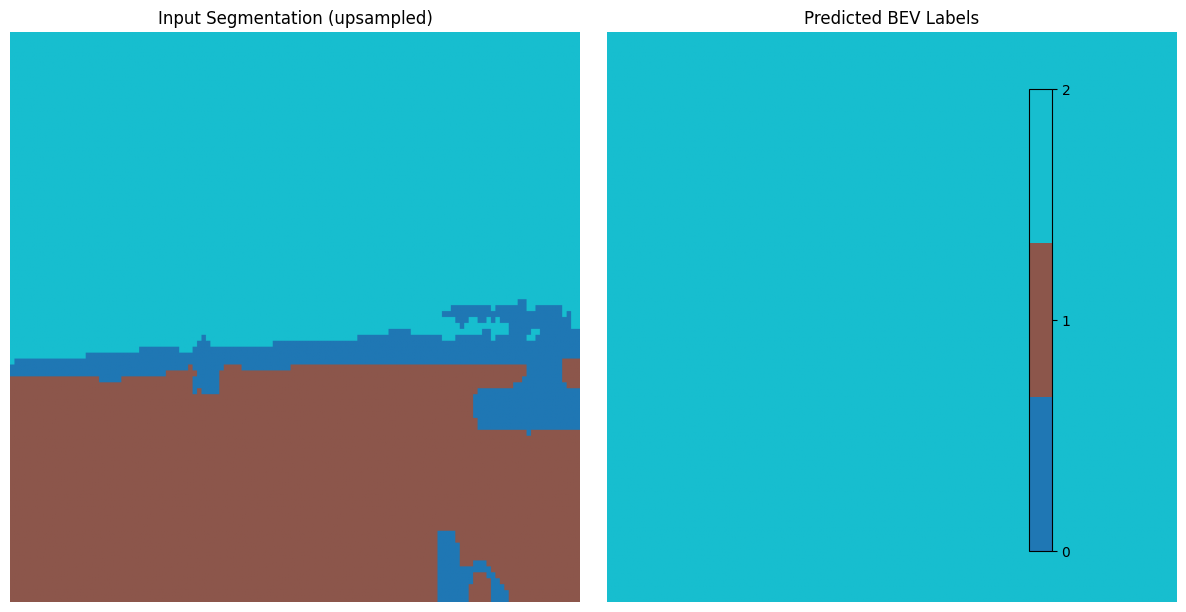

In [35]:
MASK_PATH    = "./predicted_masks/val/mask_0132.npy"
MODEL_WEIGHTS = '../RGB2BEV/enhancedvitunet_rgb2bev.pth'      # your trained mapping model
NUM_CLASSES  = 3                # <-- adjust to your setup
DEVICE       = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1) load raw mask
raw = np.load(MASK_PATH)                # shape (96,128)

# 2) one-hot → 3×96×128 tensor
inp = one_hot_rgb(raw, NUM_CLASSES)  # C×H×W
inp = inp.unsqueeze(0).to(DEVICE)       # 1×C×96×128

# 3) upsample to 384×384
inp = F.interpolate(inp, size=(384,384), mode='nearest')

# 4) load model + checkpoint
model = EnhancedViTUNet(image_size=(384,384), out_channels=NUM_CLASSES)
ckpt = torch.load(MODEL_WEIGHTS, map_location='cpu', weights_only=False)
state_dict = ckpt.get('model_state_dict', ckpt)
model.load_state_dict(state_dict)
model = model.to(DEVICE).eval()

# 5) inference
with torch.no_grad():
    bev_logits = model(inp)                    # 1×C×384×384
    bev_label  = bev_logits.argmax(1)[0].cpu().numpy()

# 6) upsample input mask for display
raw_up = Image.fromarray(raw.astype(np.uint8)) \
            .resize((384,384), Image.NEAREST)
raw_up = np.array(raw_up, dtype=int)          # 384×384

# 7) visualize side-by-side
visualize_pair(raw_up, bev_label, NUM_CLASSES)

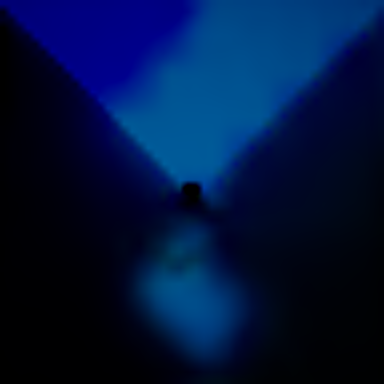

In [64]:
import torch
import torchvision.transforms as T
from torchvision.transforms import ToPILImage

raw_mask = np.load("./predicted_masks/single/mask_0001.npy")
seg_rgb = mask_to_rgb(raw_mask, {i:palette[i] for i in range(3)})  # as PIL or np.array

# 1) define your transforms exactly as in training
transform = T.Compose([
    T.Resize((384,384)),       # your ViT‐U input size
    T.ToTensor(),              # gives [0..1] floats on each channel
    # T.Normalize(mean, std)   # if you used normalization
])

# 2) load & preprocess
inp = transform(seg_rgb).unsqueeze(0).to(DEVICE)  # 1×3×384×384

# 3) inference
model = EnhancedViTUNet(image_size=(384,384), out_channels=len(palette))
ckpt   = torch.load(MODEL_WEIGHTS, map_location="cpu", weights_only=False)
sd     = ckpt.get("model_state_dict", ckpt)
model.load_state_dict(sd)
model.to(DEVICE).eval()

with torch.no_grad():
    bev_logits = model(inp)                    # 1×C×384×384
    bev_rgb  = bev_logits.squeeze(0).cpu()  # 384×384 int

bev_rgb = torch.clamp(bev_rgb, 0, 1)       # ensure in [0,1]

to_pil = ToPILImage()
bev_img = to_pil(bev_rgb)                  # PIL Image in RGB
bev_img.save("predicted_bev.png")
bev_img.show()

In [62]:
import matplotlib.pyplot as plt

def visualize(seg_rgb: Image.Image, bev_label: np.ndarray, colormap: dict):
    # show the colored seg & the predicted BEV labels
    cmap = plt.get_cmap("tab10", len(colormap))
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

    ax1.imshow(seg_rgb)
    ax1.set_title("Segmentation (RGB)")
    ax1.axis("off")

    im = ax2.imshow(bev_label, cmap=cmap, vmin=0, vmax=len(colormap)-1)
    ax2.set_title("Predicted BEV Labels")
    ax2.axis("off")

    plt.colorbar(im, ticks=range(len(colormap)), fraction=0.046, ax=[ax1,ax2])
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_1338109/694324260.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


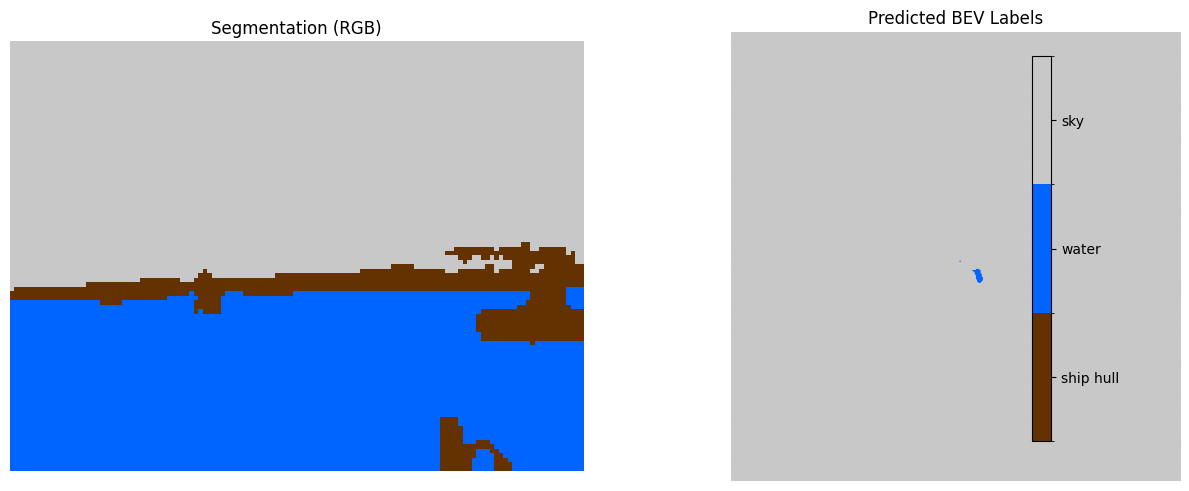

In [63]:
visualize_pair(np.array(seg_rgb), bev_label)

## push to hub

In [66]:
from huggingface_hub import login, HfApi
from datasets import Dataset, DatasetDict, Features, Value
import os

# 1. Log in interactively
login()  # This will prompt you to paste your Hugging Face token

# 2. Set metadata
username = HfApi().whoami()["name"]
dataset_name = "gazebo11-front-bev"
repo_id = f"{username}/{dataset_name}"

description = """
### Gazebo11 Front–BEV Paired Image Dataset

This dataset is collected from a static obstacle simulation environment in **Gazebo11**.
Each example includes:
- A front-view RGB camera image with a **90° field of view**
- A bird’s-eye view (BEV) top-down image that represents approximately **±100 meters**

This dataset is intended for applications in autonomous navigation, vision-to-map learning, and simulation-to-real transfer.
"""

# 3. Load paired image data as bytes
def load_image_pairs(front_dir, bev_dir):
    data = []
    fronts = sorted(os.listdir(front_dir))
    bevs = sorted(os.listdir(bev_dir))
    for front_name, bev_name in zip(fronts, bevs):
        if not front_name.endswith(".png") or not bev_name.endswith(".png"):
            continue
        with open(os.path.join(front_dir, front_name), "rb") as f_front, \
             open(os.path.join(bev_dir, bev_name), "rb") as f_bev:
            data.append({
                "file_name": front_name,
                "front_image": f_front.read(),
                "bev_image": f_bev.read(),
            })
    return data

front_dir = "../data/images_aligned/front"
bev_dir = "../data/images_aligned/bev"
data = load_image_pairs(front_dir, bev_dir)

# 4. Define dataset schema and create DatasetDict
features = Features({
    "file_name": Value("string"),
    "front_image": Value("binary"),
    "bev_image": Value("binary"),
})
hf_dataset = Dataset.from_list(data, features=features)
dataset_dict = DatasetDict({"train": hf_dataset})

# 5. Push to Hugging Face Hub
dataset_dict.push_to_hub(repo_id, private=True)

# 6. Upload README
readme_path = "README.md"
with open(readme_path, "w") as f:
    f.write(description)

# Optional: Upload README manually using HfApi (if push_to_hub doesn't overwrite README)
api = HfApi()
api.upload_file(
    path_or_fileobj=readme_path,
    path_in_repo="README.md",
    repo_id=repo_id,
    repo_type="dataset"
)


Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/14 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/14 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/14 [00:00<?, ?ba/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/hf_api.py:9692: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


CommitInfo(commit_url='https://huggingface.co/datasets/Wilbur1240/gazebo11-front-bev/commit/32bc93f4074aa01f19ad9c350f5f298b82898ee3', commit_message='Upload README.md with huggingface_hub', commit_description='', oid='32bc93f4074aa01f19ad9c350f5f298b82898ee3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Wilbur1240/gazebo11-front-bev', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Wilbur1240/gazebo11-front-bev'), pr_revision=None, pr_num=None)

In [67]:
from huggingface_hub import login, HfApi, create_repo, upload_file
import os
import shutil

# 1. Log in
login()  # Paste your token when prompted

# 2. Set model metadata
model_name = "enhanced-vit-unet-front-bev"
username = HfApi().whoami()["name"]
repo_id = f"{username}/{model_name}"
local_model_path = "../RGB2BEV/enhancedvitunet_rgb2bev.pth"  # Path to your .pth file

# 3. Create repository (if it doesn’t exist)
create_repo(repo_id=repo_id, repo_type="model", private=True, exist_ok=True)

# 4. Optional: create a local folder and write README/model card
local_dir = f"./{model_name}"
os.makedirs(local_dir, exist_ok=True)

# Move model file to local dir (optional but cleaner)
shutil.copy(local_model_path, os.path.join(local_dir, "pytorch_model.pth"))

# Create a README.md with basic info
readme_text = """
# EnhancedViTUNet for Front-to-BEV Prediction

This model takes a **front-view RGB image** and predicts a **Bird’s-Eye View (BEV)** image.

- **Architecture**: Vision Transformer (ViT) encoder + U-Net style decoder
- **Training**: On synthetic Gazebo11 simulation dataset with ROI-masked L1 + perceptual VGG loss
- **Input size**: 384×384 RGB
- **Output size**: 384×384 RGB BEV
"""

with open(os.path.join(local_dir, "README.md"), "w") as f:
    f.write(readme_text)

# 5. Upload model + README
upload_file(
    path_or_fileobj=os.path.join(local_dir, "pytorch_model.pth"),
    path_in_repo="pytorch_model.pth",
    repo_id=repo_id,
    repo_type="model"
)

upload_file(
    path_or_fileobj=os.path.join(local_dir, "README.md"),
    path_in_repo="README.md",
    repo_id=repo_id,
    repo_type="model"
)


pytorch_model.pth:   0%|          | 0.00/360M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/hf_api.py:9692: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


CommitInfo(commit_url='https://huggingface.co/Wilbur1240/enhanced-vit-unet-front-bev/commit/258be654072df5681ece6213814c972f6635211d', commit_message='Upload README.md with huggingface_hub', commit_description='', oid='258be654072df5681ece6213814c972f6635211d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Wilbur1240/enhanced-vit-unet-front-bev', endpoint='https://huggingface.co', repo_type='model', repo_id='Wilbur1240/enhanced-vit-unet-front-bev'), pr_revision=None, pr_num=None)